# Model—Machine Learning Surrogate for MuSHrooM (Testing)

In [147]:
# general imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# data loading and processing
import h5py
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [148]:
# load data (if already resized and downsampled) - otherwise, comment out and run code below
phi_data = torch.load('downscaled_data64old.pt')

C:\Users\lukas\AppData\Local\Temp\ipykernel_26000\3859097922.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  phi_data = torch.load('downscaled_data64old.pt')


In [149]:

# model training
lr_cvae = 0.001
num_epochs_cvae = 500 

lr_dnn = 0.001
num_epochs_dnn = 10000

# model data
batch_size_cvae = 32
input_dim = 64 # for square images
latent_dim = 128

batch_size_dnn = 32

# loss weighting
w_phi = 1.0
w_grad = 10.0
w_kl = 0.01

# manual parameters
N_train_batches = 38

### Define Models

In [150]:
# Encoder Network
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)  # 64x64 -> 32x32
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # 32x32 -> 16x16
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # 16x16 -> 16x16
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)  # 16x16 -> 8x8
        self.bn4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)  # 8x8 -> 8x8
        self.bn5 = nn.BatchNorm2d(256)
        
        # Fully connected layers
        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)

    def forward(self, x):
        # Apply convolution -> batch normalization -> activation
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        
        # Flatten before fully connected layers
        x = x.view(x.size(0), -1)
        
        # Compute mu and logvar for the latent space
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

Define Model Components

In [151]:
# Decoder Network
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        
        # Fully connected layer to project latent space to feature map
        self.fc = nn.Linear(latent_dim, 256 * 8 * 8)
        
        # Deconvolutional layers
        self.deconv1 = nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1)  # 8x8 -> 8x8
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)  # 8x8 -> 16x16
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)   # 16x16 -> 16x16
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)    # 16x16 -> 32x32
        self.deconv5 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)     # 32x32 -> 64x64

    def forward(self, z):
        # Project latent space to feature map
        z = F.relu(self.fc(z))
        z = z.view(z.size(0), 256, 8, 8)  # Reshape to (batch_size, 256, 8, 8)
        
        # Apply deconvolution -> activation
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = F.relu(self.deconv3(z))
        z = F.relu(self.deconv4(z))
        return torch.sigmoid(self.deconv5(z))  # Output scaled between 0 and 1



In [152]:
class CVAE(nn.Module):
    def __init__(self, latent_dim=latent_dim):
        super(CVAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std) # std just gives dimension of tensor to give back
        return mu + epsilon * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar, z # return reconstructed data, mu, logvar, and the latent state z

In [153]:
model = CVAE(latent_dim=latent_dim)
optimizer = optim.Adam(model.parameters(), lr=lr_cvae)

#### Load Model (Optional)

In [154]:
# load model
model.load_state_dict(torch.load('CVAE Training/CVAE_1/CVAE_model_1.pth'))

C:\Users\lukas\AppData\Local\Temp\ipykernel_26000\3617593774.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('CVAE Training/CVAE_1/CVAE_

<All keys matched successfully>

### Test Model

In [155]:
# get training and test data lengths
total_len = phi_data.shape[0]
train_len = N_train_batches * batch_size_cvae
test_len = total_len - train_len
# print lengths
print("Total data length: ", total_len)
print("Training data length: ", train_len)
print("Test data length: ", test_len)

# print data shape
print("Data shape: ", phi_data.shape)


# split phi_train and phi_test data
phi_train = torch.tensor(phi_data[:train_len])
phi_test = torch.tensor(phi_data[train_len:])

Total data length:  1311
Training data length:  1216
Test data length:  95
Data shape:  (1311, 64, 64)


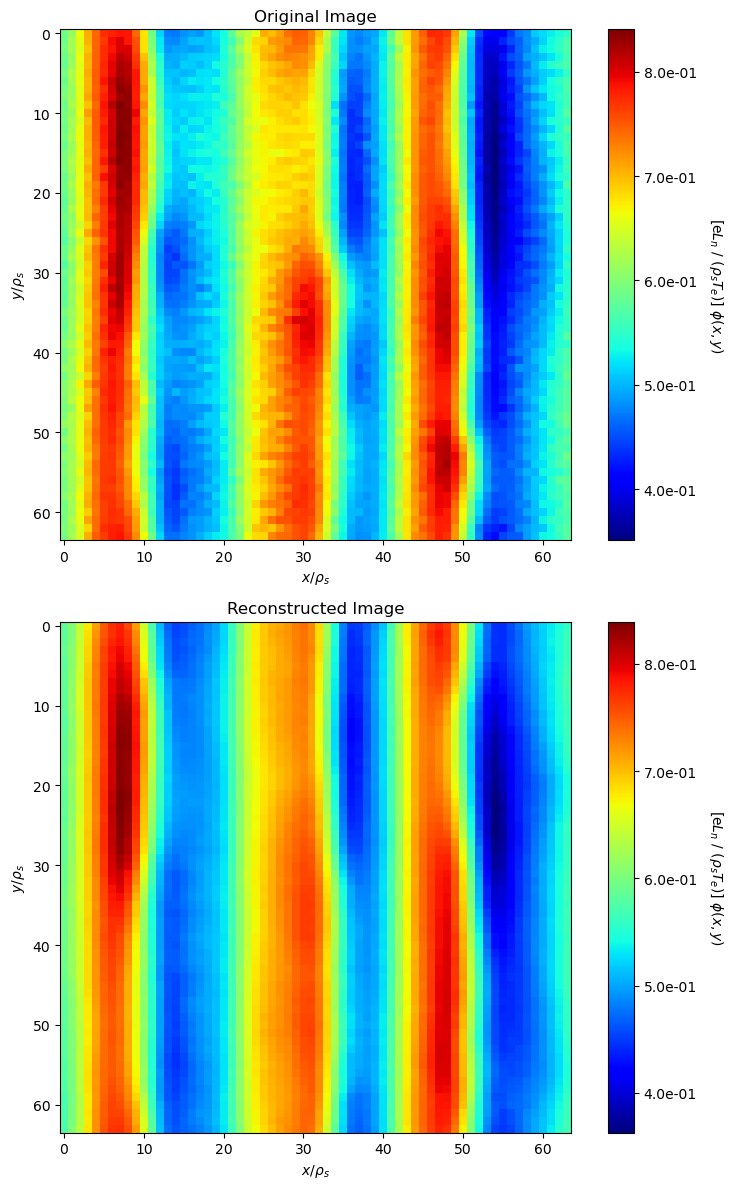

In [156]:
it = 7

test_image = phi_test[it].unsqueeze(0).unsqueeze(0)
model.eval()
with torch.no_grad():
    recon_image, mu, logvar, z = model(test_image)


# Create a single figure with two vertically-stacked subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

# Display the original image in the first subplot
cax1 = ax1.imshow(test_image.squeeze(), cmap='jet', interpolation='nearest')
cbar1 = fig.colorbar(cax1, ax=ax1, format='%.1e')
cbar1.set_label(r'[e$L_n$ / ($\rho_s T_e$)] $\phi(x, y)$', rotation=270, labelpad=20)
ax1.set_title('Original Image')
ax1.set_xlabel(r'$x / \rho_s$')
ax1.set_ylabel(r'$y / \rho_s$')

# Display the reconstructed image in the second subplot
cax2 = ax2.imshow(recon_image.squeeze(), cmap='jet', interpolation='nearest')
cbar2 = fig.colorbar(cax2, ax=ax2, format='%.1e')
cbar2.set_label(r'[e$L_n$ / ($\rho_s T_e$)] $\phi(x, y)$', rotation=270, labelpad=20)
ax2.set_title('Reconstructed Image')
ax2.set_xlabel(r'$x / \rho_s$')
ax2.set_ylabel(r'$y / \rho_s$')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig(f'CVAE Training/CVAE_1/Reconstruction_test_{it}.png')
plt.show()

### Load DNN Data

In [157]:
""" Prepare Test and Train data for the DNN model """

# initialize empty tensors to store z-vectors
z_train_data = torch.empty(train_len, latent_dim)
z_test_data = torch.empty(test_len, latent_dim)

print("phi_train shape: ", phi_train.shape)
print("phi_test shape: ", phi_test.shape)

model.eval()
with torch.no_grad():
    for i in range(train_len):
        input = phi_train[i].unsqueeze(0).unsqueeze(0)
        z_train_data[i] = model.encoder(input)[0]
        
    for i in range(test_len):
        input = phi_test[i].unsqueeze(0).unsqueeze(0)
        z_test_data[i] = model.encoder(input)[0]

model.eval()
with torch.no_grad():
    for i in range(train_len):
        input = phi_train[i].unsqueeze(0).unsqueeze(0)
        z_train_data[i] = model.encoder(input)[0]
        
    for i in range(test_len):
        input = phi_test[i].unsqueeze(0).unsqueeze(0)
        z_test_data[i] = model.encoder(input)[0]

# print shapes of data
print("Training data shape: ", z_train_data.shape)
print("Test data shape: ", z_test_data.shape)


# make copy in numpy of z_train_data and z_test_data
z_train_data_np = z_train_data.numpy()
z_test_data_np = z_test_data.numpy()

print("Input copy:", z_train_data_np[:5, 58:63])

phi_train shape:  torch.Size([1216, 64, 64])
phi_test shape:  torch.Size([95, 64, 64])
Training data shape:  torch.Size([1216, 128])
Test data shape:  torch.Size([95, 128])
Input copy: [[ 1.3979051  -0.04104599 -0.08923685 -0.02192538 -0.02101928]
 [ 1.5965492  -0.01481452 -0.07984344 -0.02411569 -0.04136908]
 [ 1.6730794   0.01523392 -0.06911942 -0.02409606 -0.05770147]
 [ 1.697168    0.04013902 -0.05666913 -0.01868459 -0.06853303]
 [ 1.592177    0.06137602 -0.05104888 -0.00615977 -0.07252945]]


### Define Dataset and create DataLoader

### Define DNN Model

In [158]:
# DNN Model
class DNN(nn.Module):
    def __init__(self, latent_dim):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, latent_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return self.fc5(x)
    
dnnmodel = DNN(latent_dim)

### Load Model

In [159]:
# load model
dnnmodel.load_state_dict(torch.load('CVAE Training/CVAE_1/DNN_model_1.pth'))

C:\Users\lukas\AppData\Local\Temp\ipykernel_26000\2851597416.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dnnmodel.load_state_dict(torch.load('CVAE Training/CVAE_1/DN

<All keys matched successfully>

### Define model manually

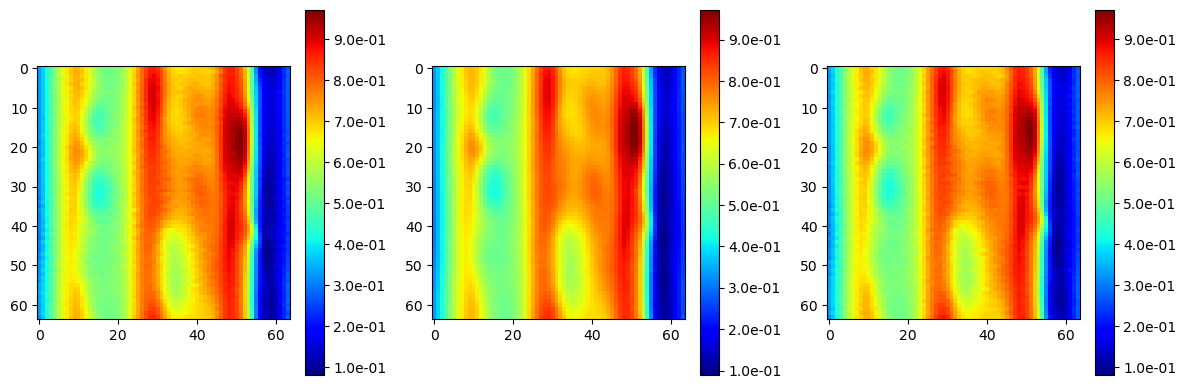

In [169]:
# z_pred = dnnmodel(z_train_data)
# z_pred_np = z_pred.detach().numpy()

# model.eval()
# with torch.no_grad():
#     # use model.decoder
#     pred_images = model.decoder(torch.tensor(z_pred))
#     print(torch.tensor(z_pred).shape)
#     input_images = model.decoder(torch.tensor(z_train_data))


def gait(x): # pass the ith image and get the preiction for the next (phi_train[it+1])
    input = x.unsqueeze(0).unsqueeze(0)
    z_input = model.encoder(input)[0]
    z_pred = dnnmodel(z_input)
    pred_image = model.decoder(z_pred.unsqueeze(0))
    return pred_image
    
x = phi_train[it]
pred_image = gait(x)
y_true = phi_train[it+1]

# plot 1x3 images with original (input), prediction and next original (input+1)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Display the original image in the first subplot
cax1 = ax1.imshow(x.squeeze(), cmap='jet', interpolation='nearest')
cbar1 = fig.colorbar(cax1, ax=ax1, format='%.1e')

# Display the reconstructed image in the second subplot
cax2 = ax2.imshow(pred_image.squeeze().detach().numpy(), cmap='jet', interpolation='nearest')
cbar2 = fig.colorbar(cax2, ax=ax2, format='%.1e')

# Display the original image in the third subplot
cax3 = ax3.imshow(y_true.squeeze(), cmap='jet', interpolation='nearest')
cbar3 = fig.colorbar(cax3, ax=ax3, format='%.1e')

plt.tight_layout()

plt.show()






### Define GAIT Model

In [ ]:
# """ Define the GAIT model"""
# # combine the CVAE and DNN models
# class GAIT(nn.Module):
#     def __init__(self, cvae, dnn):
#         super(GAIT, self).__init__()
#         self.cvae = cvae
#         self.dnn = dnn

#     def forward(self, x):
#         mu, logvar = self.cvae.encoder(x)
#         z = self.cvae.reparameterize(mu, logvar)
#         z_pred = self.dnn(z)
#         return self.cvae.decoder(z_pred), mu, logvar, z, z_pred
    
# # initialize the GAIT model
# gait = GAIT(model, dnnmodel)

### Load Gait

In [ ]:
# load model
# gait.load_state_dict(torch.load('CVAE Training/CVAE_1/GAIT_model_1.pth'))

C:\Users\lukas\AppData\Local\Temp\ipykernel_26000\1777823765.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gait.load_state_dict(torch.load('CVAE Training/CVAE_1/GAIT_m

<All keys matched successfully>

In [174]:
dnnmodel.eval()
model.eval()

# initialize empty tensors to store pred_phi
pred_phi = torch.empty(train_len, 64, 64)

with torch.no_grad():
    for i in range(train_len):
        x = phi_train[i]
        pred_phi[i] = gait(x)

pred_phi shape:  torch.Size([1216, 64, 64])
phi_train shape:  torch.Size([1216, 64, 64])


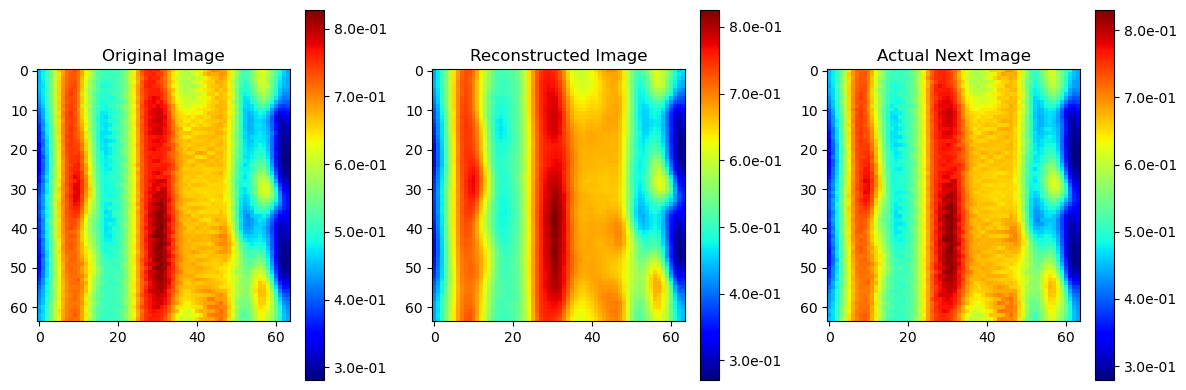

In [187]:
print("pred_phi shape: ", pred_phi.shape)
print("phi_train shape: ", phi_train.shape)

# plot the first 10 predictions along with original data and actual next time step
for i in range(1):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

    # Display the original image in the first subplot
    cax1 = ax1.imshow(phi_train[i], cmap='jet', interpolation='nearest')
    cbar1 = fig.colorbar(cax1, ax=ax1, format='%.1e')
    # add title
    ax1.set_title('Original Image')

    # Display the reconstructed image in the second subplot
    cax2 = ax2.imshow(pred_phi[i], cmap='jet', interpolation='nearest')
    cbar2 = fig.colorbar(cax2, ax=ax2, format='%.1e')
    # add title
    ax2.set_title('Reconstructed Image')

    # Display the original image in the third subplot
    cax3 = ax3.imshow(phi_train[i+1], cmap='jet', interpolation='nearest')
    cbar3 = fig.colorbar(cax3, ax=ax3, format='%.1e')
    # add title
    ax3.set_title('Actual Next Image')

    plt.tight_layout()

    plt.show()

Test GAIT Model

### Generate simulation animations

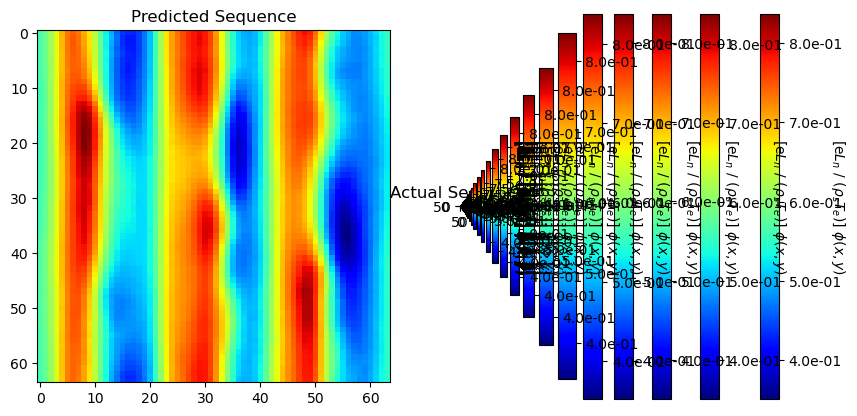

In [ ]:
phi0 = phi_test[0]

# make sequence of predictions
n = len(phi_test)-1
seq = []

# add first image to sequence
seq.append(phi0)
# make predictions
with torch.no_grad():
    for i in range(n):
        y = gait(seq[i])
        seq.append(y.squeeze().squeeze())


# make video of sequence vs actual
import matplotlib.animation as animation

fig, ax = plt.subplots(1, 2)
# set size to 10x5
fig.set_size_inches(10, 5)
ims = []

for i in range(n+1):
    im1 = ax[0].imshow(seq[i].detach().numpy(), cmap='jet')
    # set title
    ax[0].set_title('Predicted Sequence')
    im2 = ax[1].imshow(phi_test[i], cmap='jet')
    # set title
    ax[1].set_title('Actual Sequence')
    ims.append([im1, im2])
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
ani.save('CVAE Training/CVAE_1/sequence.mp4')    


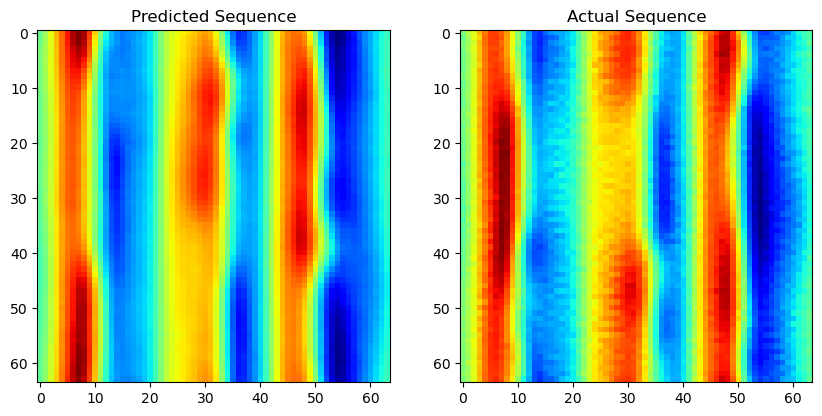

In [183]:
phi0 = phi_train[0]

# make sequence of predictions
n = len(phi_train)-1
seq = []

# add first image to sequence
seq.append(phi0)
# make predictions
with torch.no_grad():
    for i in range(n):
        y = gait(seq[i])
        seq.append(y.squeeze().squeeze())


# make video of sequence vs actual
import matplotlib.animation as animation

fig, ax = plt.subplots(1, 2)
# set size to 10x5
fig.set_size_inches(10, 5)
ims = []

for i in range(n+1):
    im1 = ax[0].imshow(seq[i].detach().numpy(), cmap='jet')
    # set title
    ax[0].set_title('Predicted Sequence')
    im2 = ax[1].imshow(phi_train[i], cmap='jet')
    # set title
    ax[1].set_title('Actual Sequence')
    ims.append([im1, im2])
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
ani.save('CVAE Training/CVAE_1/sequence_train.mp4')    

